In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time

from IPython.display import clear_output

import dali.core as D
from dali.data import LineExtractor, discover_files, batched_reducer, process_files
from dali.data.batch import LMBatch

from dali.utils import Vocab, median_smoothing, throttled
from dali import beam_search

%matplotlib inline

In [3]:
D.config.default_device = 'gpu'

In [4]:
# first 10k words from glove
GLOVE_VOCAB = '/home/sidor/projects/Dali/data/glove/vocab10k.txt'
# Bookcorpus - pretokenized
BOOKCORPUS  = '/home/sidor/datasets/bookcorpus/'

# network sizes
INPUT_SIZE = 250
HIDDENS = [250, 250]

# dataset / training parameters
MINIBATCH = 256
SENTENCES_UNTIL_MINIBATCH = 1000 * MINIBATCH
SENTENCE_LENGTH=(2, 10)

# Data loading

In [5]:
glove_vocab = Vocab()
glove_vocab.add(LineExtractor()(GLOVE_VOCAB))
glove_vocab.add(LMBatch.START_TOKEN)

In [6]:
def extract_bookcorpus(path, vocab, minibatch_size, sentences_until_minibatch=None, sentence_length_bounds=(2, 20)):
    sentences_until_minibatch = sentences_until_minibatch or 10000 * minibatch_size
    files   = discover_files(BOOKCORPUS, ".txt")
    mapper  = LineExtractor() \
              .lower()        \
              .split_spaces() \
              .bound_length(*sentence_length_bounds)
    reducer = batched_reducer(minibatch_size,
                              LMBatch.given_vocab(glove_vocab, store_originals=True),
                              sentences_until_minibatch)
    return process_files(files=files, mapper=mapper, reducer=reducer)

In [7]:
example_generator = extract_bookcorpus(BOOKCORPUS, glove_vocab, MINIBATCH, 
                                    SENTENCES_UNTIL_MINIBATCH, sentence_length_bounds=SENTENCE_LENGTH)

# Model definition 

In [8]:
class LanguageModel(object):
    def __init__(self, input_size, hiddens, vocab_size, dtype=np.float32):
        self.input_size = input_size
        self.hiddens    = hiddens
        self.vocab_size = vocab_size
        self.dtype = dtype
        
        self.encoder = D.random.uniform(-0.05, 0.05, (vocab_size, input_size), dtype=dtype)
        self.lstm    = D.StackedLSTM(input_size, hiddens, dtype=dtype)
        self.decoder = D.Layer(hiddens[-1], vocab_size, dtype=dtype)
    
    def error(self, batch):
        error = D.Mat(1,1)
        state = self.lstm.initial_states()
        for ts in range(batch.timesteps):
            inputs  = batch.inputs(ts)
            targets = batch.targets(ts)
            if inputs:
                encoded = self.encoder[batch.inputs(ts)]
            else:
                encoded = Mat(1, self.input_size)
            state = self.lstm.activate(encoded, state)
            if targets:
                decoded = self.decoder.activate(state[-1].hidden)
                error = error + D.MatOps.softmax_cross_entropy(decoded, targets).sum()
        return error
    
    def sample(self, priming, temperature=1.0, **kwargs):
        with D.NoBackprop():
            state = self.lstm.initial_states()
            for word_idx in priming:
                encoded = self.encoder[word_idx]
                state = self.lstm.activate(encoded, state)
            def candidate_scores(state):
                return D.MatOps.softmax(self.decoder.activate(state[-1].hidden), temperature=temperature).log()
            def make_choice(state, candidate_idx):
                encoded = self.encoder[candidate_idx]
                return self.lstm.activate(encoded, state)

            return beam_search(state,
                               candidate_scores,
                               make_choice,
                               **kwargs)
    
    def parameters(self):
        return [self.encoder] + self.lstm.parameters() + self.decoder.parameters()

In [9]:
def show_reconstructions(model, words, temperature=1.0):
    for solution, score, _ in model.sample(glove_vocab.encode([LMBatch.START_TOKEN] + words), 
                                           eos_symbol=glove_vocab.eos,
                                           max_sequence_length=20,
                                           blacklist=[glove_vocab.unk],
                                           temperature=temperature):
        score = math.exp(score.w[0])
        priming = ' '.join(words)
        solution = ' '.join(glove_vocab.decode(solution, False))
        print('%f => [%s] %s' % (score, priming, solution))

In [10]:
model  = LanguageModel(INPUT_SIZE, HIDDENS, len(glove_vocab))

In [11]:
params = model.parameters()
s = D.AdaGrad(params)
s.step_size = 0.003

# Training

In [12]:
error_evolution = []

In [13]:
total_error, num_words = 0.0, 0
batch_time, num_batches = 0.0, 0

@throttled(5)
def report(example):
    if num_batches == 0 or num_words == 0 or abs(batch_time) < 1e-6:
        return
    clear_output()
    print('Error:             ', total_error / num_words)
    print('Time per batch:    ', batch_time  / num_batches)
    print('Words per second:  ', num_words   / batch_time )
    print('Batches processed: ', num_batches)
    show_reconstructions(model, example)
    sys.stdout.flush()
    

batch_end_time, batch_start_time = None, None

for batch in example_generator:    
    batch_start_time = time.time()
    error = model.error(batch)

    error.grad()
    D.Graph.backward()
    s.step(params)
    batch_end_time = time.time()

    error_evolution.append(error.w[0,0] / sum(batch.sentence_lengths))
    
    total_error += error.w[0, 0]
    num_words   += sum(batch.sentence_lengths)
        
    if batch_end_time is not None and batch_start_time is not None:
        batch_time += batch_end_time - batch_start_time
    num_batches    += 1
    
    example = batch.sentences[0]
    example_len = random.randint(1, len(example))
    
    report(example[:example_len])

Error:              5.39217371803
Time per batch:     0.8139708504747989
Words per second:   2469.5225901671392
Batches processed:  134
0.075618 => [‘same travel] **EOS**
0.006036 => [‘same travel] . **EOS**
0.003867 => [‘same travel] , **EOS**
0.000664 => [‘same travel] . . **EOS**
0.000098 => [‘same travel] . . . **EOS**


KeyboardInterrupt: 

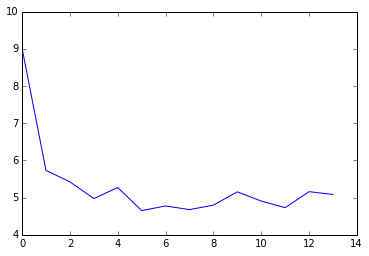

In [17]:
plt.plot(median_smoothing(error_evolution, window=len(error_evolution) // 20 )[::10] )

In [22]:
len(error_evolution)

59101

In [16]:
show_reconstructions(model, "where did".split(' '), temperature=0.05)

0.387494 => [where did] **EOS**
0.002209 => [where did] . **EOS**
0.000005 => [where did] . . **EOS**
0.000000 => [where did] . . . **EOS**
0.000000 => [where did] , **EOS**


In [24]:
openf = False

import pickle

if openf:
    with open("/home/sidor/tmp/lm.dali", "rb") as f:
        loaded_model = pickle.load(f)
else:
    with open("/home/sidor/tmp/lm.dali", "wb") as f:
        pickle.dump(model, f)
        

In [26]:
openf = False

import pickle

if openf:
    with open("/home/sidor/tmp/lm-solver.dali", "rb") as f:
        loaded_s = pickle.load(f)
else:
    with open("/home/sidor/tmp/lm-solver.dali", "wb") as f:
        pickle.dump(s, f)
#batches_processed = 59094

In [65]:
model.__class__ = LanguageModel